TODO
1. _
2. degug pixelate (fix padding)
3. optimize pixelate

In [539]:
#%pip install opencv-python

import cv2
import numpy as np
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D

In [540]:
# returns the Euclidean distance between two rgb colors
def color_distance(color0, color1):
    # Convert to int16 or float32 to prevent overflow
    r0, g0, b0 = color0
    r1, g1, b1 = color1
    
    # Compute squared differences
    r_delta_sqrd = (r1 - r0) ** 2
    g_delta_sqrd = (g1 - g0) ** 2
    b_delta_sqrd = (b1 - b0) ** 2

    # Compute Euclidean distance
    distance = np.sqrt(r_delta_sqrd + g_delta_sqrd + b_delta_sqrd)
    return distance

In [541]:
def pad_image(image):    
    padded_image = np.pad(image, pad_width=((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=-1)
    
    return padded_image

def replace_pads_with_black(padded_image):
    # Create a copy for visualization
    black_image = np.copy(padded_image)
    
    # Create a mask for padding pixels (-1)
    mask = (black_image == -1)
    
    # Replace padding values with 0 (black)
    black_image[mask] = 0
    
    # Clip values to valid range and convert to uint8 for proper display
    black_image = np.clip(black_image, 0, 255).astype(np.uint8)
    
    return black_image

In [542]:
def get_best_candidate(group_candidates, group_mask):
    """
    Selects the best candidate from a list of (distance, (x, y)) tuples.

    Cases:
    1. If multiple candidates have the same minimum distance, select the first one that is already in a group.
    2. If there is a single best candidate, return it.

    :param group_candidates: List of tuples (distance, (x, y))
    :param group_mask: The mask storing group assignments (-1 if not assigned)
    :return: (best_x, best_y) coordinates of the best candidate
    """

    # Sort by distance first
    group_candidates.sort(key=lambda p: p[0])
    
    # Find the first candidate that is already in a group
    for i in range(len(group_candidates)):
        (x, y) = group_candidates[i][1]
        if group_mask[y, x] != -1:  # If the candidate has a group
            return group_candidates[i]

    # If no candidates are already in a group, return the closest one
    return group_candidates[0]  

In [543]:
def group_pixels(image, threshold):
  # initialize locals
  groups = []
  rows, cols = image.shape[:2]

  # used to store a map of the groups
  group_mask = np.full((rows, cols), -1, dtype=np.float32)
  # show_image(group_mask, "original group mask")
  show_image(image, "original image")

  # BUG: padding and kernel issues
  padded_image = pad_image(image)
  # converted = replace_pads_with_black(padded_image)
  # show_image(converted, "padded image")

  # Apply kernel
  for i in range(rows):
    for j in range(cols):
      region = padded_image[i:i+3, j:j+3]
      # display_kernel_region(region)
      group_candidates = []

      # target is the center pixel in the kernel
      target = region[1, 1]

      # traverse the kernel region and compare neighbours to target
      for y in range(0, 3):
        for x in range(0, 3):

          # only check neighbours (not target itself) and non-padding points
          if ((x, y) != (1, 1) and region[y, x][0] != -1):
            # if the Euc. distance between target and neighbour < threshold
            # add the (distance, neighbour coords) to list of candidates for
            # which group to add the target to
            #
            # NOTE: the neighbour coords will be the current target coords
            # shifted by the current pixel location in the kernel
            dist = color_distance(target, region[y, x])
            if (dist < threshold):
              # Adjust the kernel offsets correctly relative to the original image
              X = j + (x - 1)  # x - 1 because kernel is 3x3, and (1,1) is the center
              Y = i + (y - 1)  # y - 1 for same reason

              group_candidates.append((dist, (X, Y)))

      # no candidates found -> assign to new group
      if (len(group_candidates) == 0):
        groups.append(int(len(groups)))
        group_mask[i, j] = groups[-1]

      # candidates found -> assign to best (min dist value) neighbour
      # NOTE: if all have the same distance, we should assign to the first
      #       neighbour with a group, otherwise make new one
      else:
        best_candidate = get_best_candidate(group_candidates, group_mask)

        bestX, bestY = best_candidate[1]

        # best candidate not in group -> create new group and add target / best to group
        if (group_mask[bestY, bestX] == -1):
          groups.append(int(len(groups)))

          #test
          group_mask[i, j] = group_mask[bestY, bestX] = groups[-1]

        # best candidate in group -> add target to best's group
        else:
          group_mask[i, j] = group_mask[bestY, bestX]

  #show_image_3d(group_mask, "final group mask")
  return group_mask, groups

In [544]:
def average_groups(groups, group_mask, image):
  for group in groups:
    group_region = image[group_mask == group]
    group_avg = np.mean(group_region, axis=0)
    image[group_mask == group] = group_avg

  return image

In [545]:
def color_segment(image, threshold=0):
    # group all pixels with color distance < threshold as one
    group_mask, groups = group_pixels(image, threshold)

    # for each group, assign color as group average
    avged_img = average_groups(groups, group_mask, image)

    # Ensure the result is of type uint8
    avged_img = np.clip(avged_img, 0, 255).astype(np.uint8)

    # return image
    return avged_img

### Test

In [546]:
def show_image(mat, title):
    # Display the image using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(mat)
    plt.axis("off")  # Hide axes
    plt.title(title)
    plt.show()


def show_image_3d(matrix, title):
    # Create a meshgrid for the x and y coordinates
    x = np.arange(matrix.shape[1])  # Columns
    y = np.arange(matrix.shape[0])  # Rows
    x, y = np.meshgrid(x, y)

    # Create the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D surface
    ax.plot_surface(x, y, matrix, cmap='viridis')

    # Set the title
    ax.set_title(title)

    # Display the plot
    plt.show()

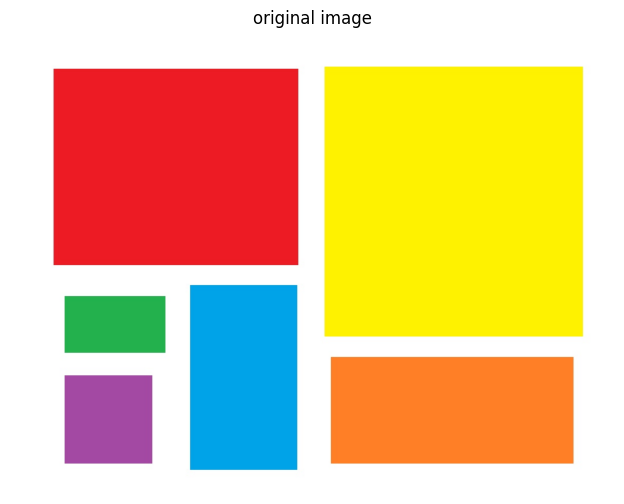

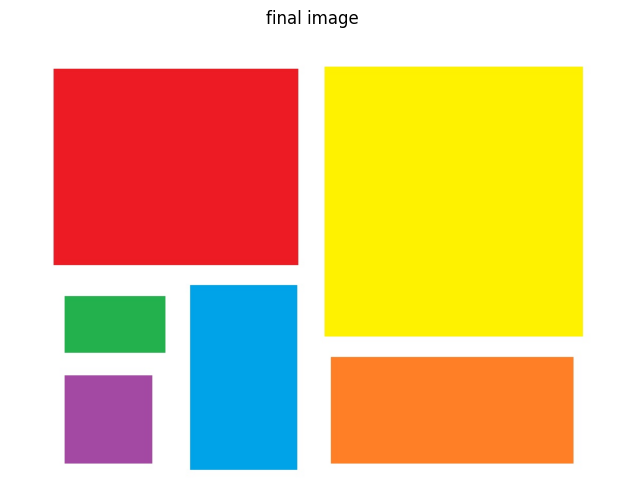

In [547]:
image = cv2.imread("Test Images\\mixed_color_blocks.jpg", cv2.IMREAD_COLOR_RGB).astype(np.int64)

# note for threshold, think about the max you can span diagonally within a color cube,
# there essentially is a limit on the euclidean distance between rgb pixels because
# you can only be so far away from another color.
final_image = color_segment(image, threshold=1)

show_image(final_image, 'final image')